# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [79]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-win_amd64.whl (35.5 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ganes\\AppData\\Roaming\\Python\\Python39\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [3]:
pip install labelme

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
!labelme

'labelme' is not recognized as an internal or external command,
operable program or batch file.


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [5]:
images = tf.data.Dataset.list_files('C:\\Users\\ganes\\Project\\mydataset\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: C:\\Users\\ganes\\Project\\mydataset\\images\\*.jpg'

In [6]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [9]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [67]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [10]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [11]:
plot_images = image_generator.next()

NameError: name 'image_generator' is not defined

NameError: name 'plot_images' is not defined

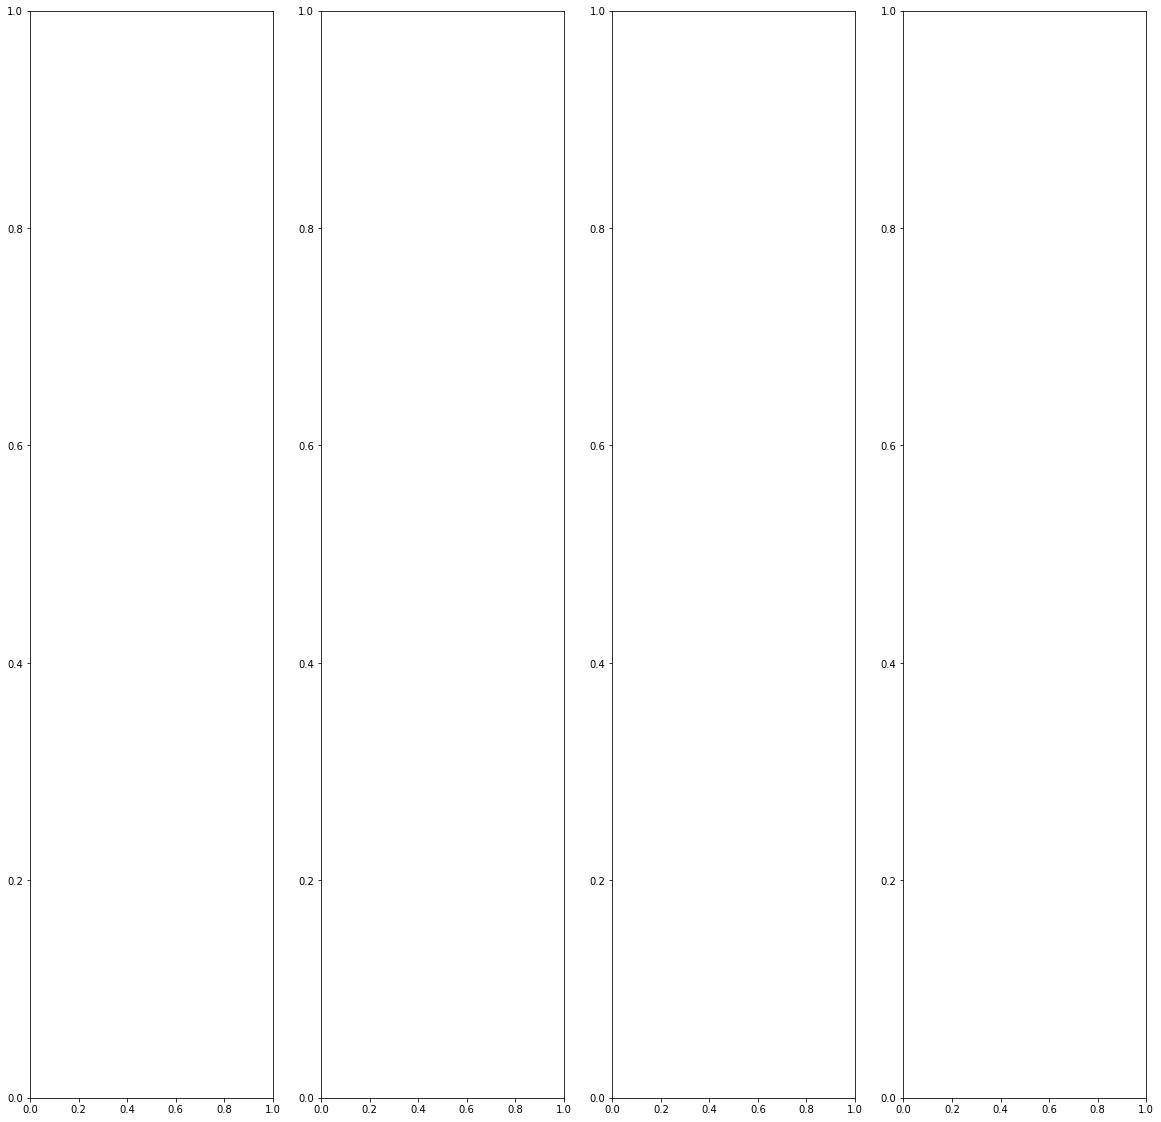

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [77]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('C:\\Users\\ganes\\Project\\mydataset', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('C:\\Users\\ganes\\Project\\mydataset','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('C:\\Users\\ganes\\Project\\mydataset',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [14]:
pip install -U albumentations --no-binary qudida,albumentations

  Using cached scikit_image-0.17.2-cp36-cp36m-win_amd64.whl (11.5 MB)
  Using cached PyYAML-6.0-cp36-cp36m-win_amd64.whl (153 kB)
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Using cached imageio-2.15.0-py3-none-any.whl (3.3 MB)
Skipping wheel build for albumentations, due to binaries being disabled for it.
Skipping wheel build for qudida, due to binaries being disabled for it.
    Running setup.py install for qudida: started
    Running setup.py install for qudida: finished with status 'done'
    Running setup.py install for albumentations: started
    Running setup.py install for albumentations: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [15]:
import albumentations as alb

In [57]:
augmentor = alb.Compose([alb.RandomCrop(width=416, height=416), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [58]:
img = cv2.imread(os.path.join('C:\\Users\\ganes\\Project\\mydataset','train', 'images','526702_1954-04-08_2008.jpg'))

In [59]:
with open(os.path.join('C:\\Users\\ganes\\Project\\mydataset', 'train', 'labels', '526702_1954-04-08_2008.json'), 'r') as f:
    label = json.load(f)

In [60]:
label['shapes'][0]['points']

[[146.0, 52.88888888888889], [233.55555555555554, 131.1111111111111]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [61]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [62]:
coords

[146.0, 52.88888888888889, 233.55555555555554, 131.1111111111111]

In [63]:
coords = list(np.divide(coords, [416,416,416,416]))

In [64]:
coords

[0.35096153846153844,
 0.12713675213675216,
 0.5614316239316239,
 0.3151709401709401]

### 4.4 Apply Augmentations and View Results

In [65]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [66]:
augmented['bboxes'][0][2:]

(0.5614316239316239, 0.8728632478632479)

In [67]:
augmented['bboxes']

[(0.35096153846153844,
  0.6848290598290598,
  0.5614316239316239,
  0.8728632478632479)]

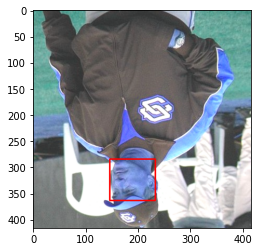

In [68]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [416,416]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [416,416]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [72]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('C:\\Users\\ganes\\Project\\mydataset', partition, 'images')):
        img = cv2.imread(os.path.join('C:\\Users\\ganes\\Project\\mydataset', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('C:\\Users\\ganes\\Project\\mydataset', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [416,416,416,416]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('C:\\Users\\ganes\\Project\\mydataset\\aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('C:\\Users\\ganes\\Project\\mydataset\\aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [73]:
train_images = tf.data.Dataset.list_files('C:\\Users\\ganes\\Project\\mydataset\\aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [74]:
test_images = tf.data.Dataset.list_files('C:\\Users\\ganes\\Project\\mydataset\\aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [75]:
val_images = tf.data.Dataset.list_files('C:\\Users\\ganes\\Project\\mydataset\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [76]:
train_images.as_numpy_iterator().next()

array([[[2.74509820e-03, 3.92156886e-03, 0.00000000e+00],
        [3.10588211e-01, 2.55294114e-01, 1.47450969e-01],
        [3.02875817e-01, 2.44052291e-01, 1.22483663e-01],
        ...,
        [1.52496141e-04, 3.26801371e-03, 0.00000000e+00],
        [6.40506158e-04, 1.17654237e-03, 0.00000000e+00],
        [7.01521349e-04, 9.15048644e-04, 0.00000000e+00]],

       [[3.66013101e-03, 3.00653582e-03, 0.00000000e+00],
        [3.08196098e-01, 2.49372557e-01, 1.42705873e-01],
        [3.09607834e-01, 2.43333325e-01, 1.25490203e-01],
        ...,
        [2.43921563e-01, 2.19999999e-01, 1.61960781e-01],
        [2.36862659e-01, 2.12941095e-01, 1.54901892e-01],
        [2.23267972e-01, 1.99346408e-01, 1.41307205e-01]],

       [[4.46623238e-03, 2.50544539e-03, 0.00000000e+00],
        [3.03529412e-01, 2.39019617e-01, 1.35098040e-01],
        [3.12091500e-01, 2.38671020e-01, 1.21023960e-01],
        ...,
        [2.60566413e-01, 2.10566521e-01, 1.10239625e-01],
        [2.59607643e-01, 2.04

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [77]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [78]:
train_labels = tf.data.Dataset.list_files('C:\\Users\\ganes\\Project\\mydataset\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [79]:
test_labels = tf.data.Dataset.list_files('C:\\Users\\ganes\\Project\\mydataset\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [80]:
val_labels = tf.data.Dataset.list_files('C:\\Users\\ganes\\Project\\mydataset\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [81]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [82]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4500, 4500, 1080, 1080, 1680, 1680)

### 7.2 Create Final Datasets (Images/Labels)

In [83]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [84]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [85]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [86]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3638, 0.1965, 0.5605, 0.3655],
        [0.322 , 0.8867, 0.7197, 0.9946],
        [0.3457, 0.267 , 0.774 , 0.812 ],
        [0.492 , 0.2756, 0.584 , 0.3794],
        [0.6533, 0.5684, 0.7334, 0.625 ],
        [0.29  , 0.188 , 0.745 , 0.8003],
        [0.4897, 0.1486, 0.6147, 0.3687],
        [0.3135, 0.3462, 0.416 , 0.438 ]], dtype=float16))

### 7.3 View Images and Annotations

In [87]:
data_samples = train.as_numpy_iterator()

In [98]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


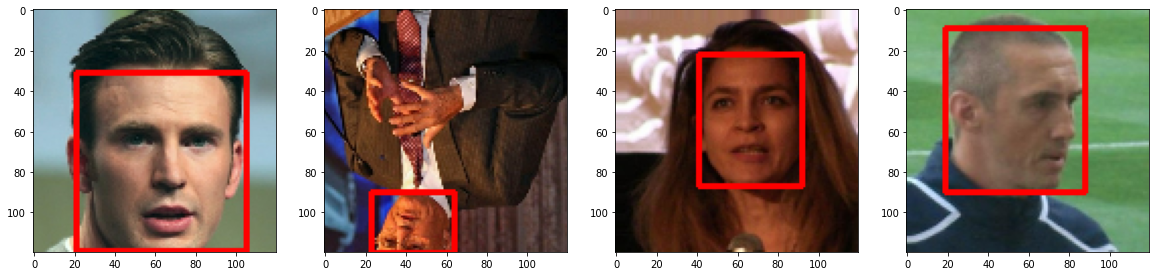

In [99]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [100]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [101]:
vgg = VGG16(include_top=False)

In [102]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [104]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [105]:
facetracker = build_model()

In [106]:
facetracker.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
_______________________________________________________________________________________

In [107]:
X, y = train.as_numpy_iterator().next()

In [108]:
X.shape

(8, 120, 120, 3)

In [109]:
classes, coords = facetracker.predict(X)

In [110]:
classes, coords

(array([[0.37440372],
        [0.3125269 ],
        [0.27382076],
        [0.44703066],
        [0.37011626],
        [0.2909662 ],
        [0.3270715 ],
        [0.23735893]], dtype=float32),
 array([[0.7382759 , 0.5527351 , 0.51509327, 0.53783065],
        [0.7887745 , 0.4808782 , 0.48970342, 0.6448942 ],
        [0.6853311 , 0.5382446 , 0.5904565 , 0.46331298],
        [0.7749927 , 0.4992856 , 0.5817279 , 0.42029342],
        [0.72683096, 0.52282035, 0.52918583, 0.41915295],
        [0.68762857, 0.58085614, 0.6068762 , 0.42582458],
        [0.7605432 , 0.5124584 , 0.49565223, 0.5930376 ],
        [0.6932484 , 0.5202574 , 0.48859367, 0.38438296]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [111]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [112]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [113]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [114]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [115]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.9630923>

In [116]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8262181>

In [117]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.9630923>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [118]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [119]:
model = FaceTracker(facetracker)

In [120]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [121]:
logdir='logs'

In [122]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [123]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
  1/563 [..............................] - ETA: 0s - total_loss: 9.4916 - class_loss: 0.8991 - regress_loss: 9.0421WARNING:tensorflow:From C:\Users\ganes\.conda\envs\gpu2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 28/563 [>.............................] - ETA: 12:12 - total_loss: 2.1608 - class_loss: 0.6239 - regress_loss: 1.8489

KeyboardInterrupt: 

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()